In [1]:
# make a comparison of just the different blood groups
# Single Var pred : Only Blood Type and no other features-
# Pick the 5 and 10 best features and 

In [2]:
import pandas as pd
import numpy as np
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve 

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.svm import SVC

from sklearn.model_selection import KFold, cross_val_score

import copy
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
unneeded_data = ['Place_of_isolation','Patient_In','Patient_out']
catigorical_data=['Blood_Group','CONTROL_blood_group','Risk_Factor']
labels = ['Severeity','Outcome']
droped_col = unneeded_data+catigorical_data+labels

In [4]:
df = pd.read_csv("Covid-19_dataset.csv",header=1)


df['is_Male'] = pd.get_dummies(df['Gender'])['MALE']#one hot encoding gender so male = #1 and female = 0

blood_types = pd.get_dummies(df['Blood_Group']).columns
blood_group_columns = pd.get_dummies(df[['Blood_Group','CONTROL_blood_group']]).columns


df = pd.concat([df, pd.get_dummies(df[['Blood_Group','CONTROL_blood_group','Risk_Factor','Infection_type']])], axis=1)



df = df.drop(['Blood_Group','CONTROL_blood_group','Risk_Factor','Infection_type','Gender','Place_of_isolation','Patient_In','Patient_out'],axis=1)

columns = df.columns



# getting rid of blank values
print("before",df.shape)
for name in columns:
    df = df[df[name] != " "]
    df = df.dropna()
    
label_Severeity = df['Severeity'] #Severeity vs Outcome
label_Outcome = df['Outcome']
df = df.drop(['Severeity','Outcome'],axis=1)


df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce'))#strings to numeric
all_columns = df.columns
# df = df.reset_index()

print("after",df.shape)





before (5668, 57)
after (5641, 55)


In [5]:
blood_type_labels =[]
control_blood_type_labels = []
for i in blood_group_columns:
    if("CONTROL_" in i):
        control_blood_type_labels.append(i)
    else:
        blood_type_labels.append(i)

In [6]:
df_blood_data = copy.deepcopy(df[blood_type_labels])
df_CONTROL_blood_data = copy.deepcopy(df[control_blood_type_labels])

In [7]:
df_blood_data

,Blood_Group_A+,Blood_Group_A-,Blood_Group_AB+,Blood_Group_AB-,Blood_Group_B+,Blood_Group_B-,Blood_Group_O+,Blood_Group_O-
0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
5663,0,0,0,0,1,0,0,0
5664,0,0,0,0,1,0,0,0
5665,0,0,0,0,1,0,0,0
5666,1,0,0,0,0,0,0,0


In [8]:
df_CONTROL_blood_data

,CONTROL_blood_group_A+,CONTROL_blood_group_A-,CONTROL_blood_group_AB+,CONTROL_blood_group_AB-,CONTROL_blood_group_B+,CONTROL_blood_group_B-,CONTROL_blood_group_O+,CONTROL_blood_group_O-
0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
5663,0,0,0,0,0,0,1,0
5664,0,0,0,0,1,0,0,0
5665,0,0,0,0,0,0,1,0
5666,1,0,0,0,0,0,0,0


In [9]:
df_blood_data[df_blood_data['Blood_Group_A+']== 1]

,Blood_Group_A+,Blood_Group_A-,Blood_Group_AB+,Blood_Group_AB-,Blood_Group_B+,Blood_Group_B-,Blood_Group_O+,Blood_Group_O-
0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
14,1,0,0,0,0,0,0,0
17,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
5655,1,0,0,0,0,0,0,0
5660,1,0,0,0,0,0,0,0
5661,1,0,0,0,0,0,0,0
5666,1,0,0,0,0,0,0,0


In [10]:
label_Severeity.unique()

array(['Moderate', 'Mild', 'Severe', 'Critical'], dtype=object)

In [11]:
label_Severeity == 'Moderate'

0        True
1       False
2       False
3        True
4        True
        ...  
5663     True
5664    False
5665    False
5666    False
5667    False
Name: Severeity, Length: 5641, dtype: bool

In [12]:
label_Outcome

0       Recovered
1       Recovered
2            Died
3       Recovered
4       Recovered
          ...    
5663    Recovered
5664         Died
5665         Died
5666         Died
5667         Died
Name: Outcome, Length: 5641, dtype: object

In [13]:


def CrossValAndAUC_severity(model,severity_level,K=10): 
    plt.figure()
    %matplotlib inline
    

    for bt in blood_type_labels:
        Blood_Data = df_blood_data[df_blood_data[bt]== 1]
        y = label_Severeity[df_blood_data[bt]== 1]
        y = label_Severeity[df_blood_data[bt]== 1] == severity_level
        
        if(len(y.unique()) == 1):
            print(f"No {severity_level} samples for the {bt}")
            continue;
        
#         y = y.map(lambda x: 1 if x == severity_level else 0)




#         crossVal_model = copy.deepcopy(model)
#         #10 Fold cross validation
#         kf = KFold(n_splits=K, shuffle=True)
#         scores = cross_val_score(crossVal_model, Blood_Data, y, cv=kf)
#         print(f" {severity_level} {bt} | {K} Forld cross validation average: {scores.mean()}")

#         model.fit(Blood_Data,y)




        # Training ONLY on the training set to get AUC:
        tempModel = copy.deepcopy(model)
        model.fit(Blood_Data, y)
        predict = model.predict(Blood_Data)
        prob = model.predict_proba(Blood_Data)
        fpr, tpr, thresholds = metrics.roc_curve(y, prob[:,1])
        AUC = metrics.auc(fpr, tpr)
        
        lblg = f"{severity_level} / {bt}: {AUC}"
        print(lblg)
        plt.plot(fpr, tpr,label=lblg)


    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.figlegend()
    plt.show()


Moderate Logistic Regression
Moderate / Blood_Group_A+: 0.5
Moderate / Blood_Group_A-: 0.5
Moderate / Blood_Group_AB+: 0.5
Moderate / Blood_Group_AB-: 0.5
Moderate / Blood_Group_B+: 0.5
Moderate / Blood_Group_B-: 0.5
Moderate / Blood_Group_O+: 0.5
Moderate / Blood_Group_O-: 0.5


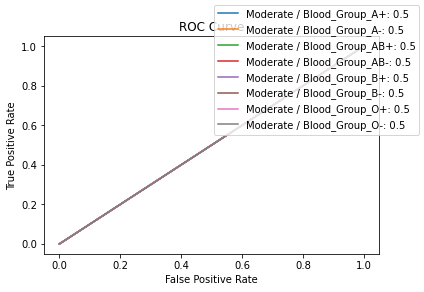

In [14]:
print("Moderate Logistic Regression")
my_logreg = LogisticRegression(max_iter=10000)
CrossValAndAUC_severity(my_logreg,'Moderate')

Mild Logistic Regression
Mild / Blood_Group_A+: 0.5
Mild / Blood_Group_A-: 0.5
Mild / Blood_Group_AB+: 0.5
Mild / Blood_Group_AB-: 0.5
Mild / Blood_Group_B+: 0.5
Mild / Blood_Group_B-: 0.5
Mild / Blood_Group_O+: 0.5
Mild / Blood_Group_O-: 0.5


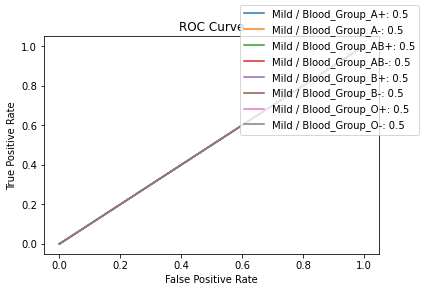

In [15]:
print("Mild Logistic Regression")
my_logreg = LogisticRegression(max_iter=10000)
CrossValAndAUC_severity(my_logreg,'Mild')

Severe Logistic Regression
Severe / Blood_Group_A+: 0.5
Severe / Blood_Group_A-: 0.5
Severe / Blood_Group_AB+: 0.5
Severe / Blood_Group_AB-: 0.5
Severe / Blood_Group_B+: 0.5
Severe / Blood_Group_B-: 0.5
Severe / Blood_Group_O+: 0.5
No Severe samples for the Blood_Group_O-


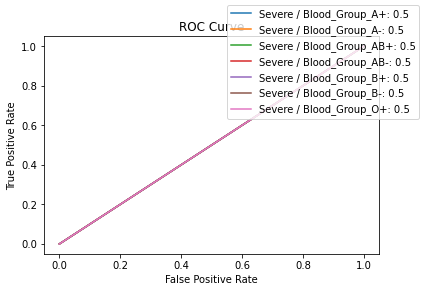

In [16]:
print("Severe Logistic Regression")
my_logreg = LogisticRegression(max_iter=10000)
CrossValAndAUC_severity(my_logreg,'Severe')

Critical Logistic Regression
Critical / Blood_Group_A+: 0.5
Critical / Blood_Group_A-: 0.5
Critical / Blood_Group_AB+: 0.5
No Critical samples for the Blood_Group_AB-
Critical / Blood_Group_B+: 0.5
Critical / Blood_Group_B-: 0.5
Critical / Blood_Group_O+: 0.5
Critical / Blood_Group_O-: 0.5


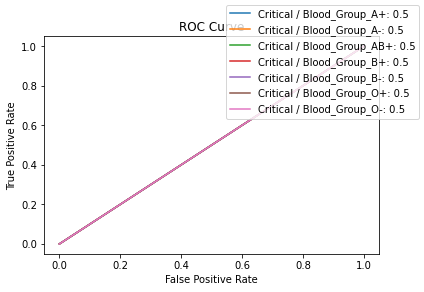

In [17]:
print("Critical Logistic Regression")
my_logreg = LogisticRegression(max_iter=10000)
CrossValAndAUC_severity(my_logreg,'Critical')

Moderate Decision Tree
Moderate / Blood_Group_A+: 0.5
Moderate / Blood_Group_A-: 0.5
Moderate / Blood_Group_AB+: 0.5
Moderate / Blood_Group_AB-: 0.5
Moderate / Blood_Group_B+: 0.5
Moderate / Blood_Group_B-: 0.5
Moderate / Blood_Group_O+: 0.5
Moderate / Blood_Group_O-: 0.5


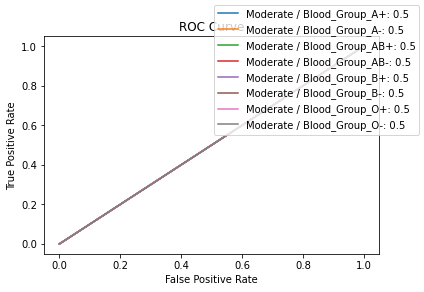

In [18]:
print("Moderate Decision Tree")
my_DecisionTree = DecisionTreeClassifier(random_state=4)
CrossValAndAUC_severity(my_DecisionTree,'Moderate')

Mild Decision Tree
Mild / Blood_Group_A+: 0.5
Mild / Blood_Group_A-: 0.5
Mild / Blood_Group_AB+: 0.5
Mild / Blood_Group_AB-: 0.5
Mild / Blood_Group_B+: 0.5
Mild / Blood_Group_B-: 0.5
Mild / Blood_Group_O+: 0.5
Mild / Blood_Group_O-: 0.5


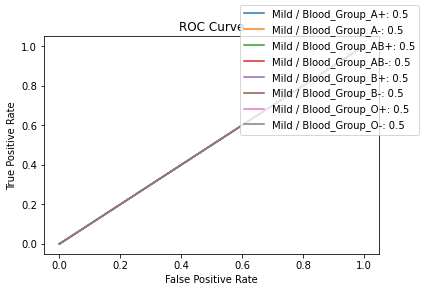

In [19]:
print("Mild Decision Tree")
my_DecisionTree = DecisionTreeClassifier(random_state=4)
CrossValAndAUC_severity(my_DecisionTree,'Mild')

Severe Decision Tree
Severe / Blood_Group_A+: 0.5
Severe / Blood_Group_A-: 0.5
Severe / Blood_Group_AB+: 0.5
Severe / Blood_Group_AB-: 0.5
Severe / Blood_Group_B+: 0.5
Severe / Blood_Group_B-: 0.5
Severe / Blood_Group_O+: 0.5
No Severe samples for the Blood_Group_O-


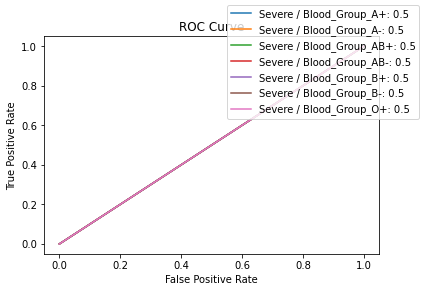

In [20]:
print("Severe Decision Tree")
my_DecisionTree = DecisionTreeClassifier(random_state=4)
CrossValAndAUC_severity(my_DecisionTree,'Severe')

Critical Decision Tree
Critical / Blood_Group_A+: 0.5
Critical / Blood_Group_A-: 0.5
Critical / Blood_Group_AB+: 0.5
No Critical samples for the Blood_Group_AB-
Critical / Blood_Group_B+: 0.5
Critical / Blood_Group_B-: 0.5
Critical / Blood_Group_O+: 0.5
Critical / Blood_Group_O-: 0.5


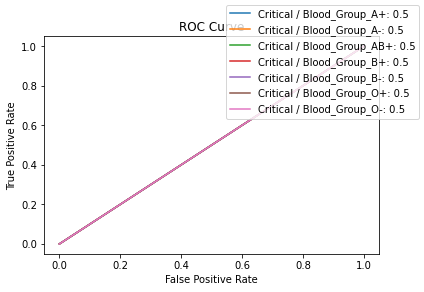

In [21]:
print("Critical Decision Tree")
my_DecisionTree = DecisionTreeClassifier(random_state=4)
CrossValAndAUC_severity(my_DecisionTree,'Critical')

In [22]:
# print("Random Forest")
# my_RandomForest = RandomForestClassifier(n_estimators=29, bootstrap=True, random_state=4)
# CrossValAndAUC(my_RandomForest)

Random Forest Classifier
Moderate / Blood_Group_A+: 0.5
Moderate / Blood_Group_A-: 0.5
Moderate / Blood_Group_AB+: 0.5
Moderate / Blood_Group_AB-: 0.5
Moderate / Blood_Group_B+: 0.5
Moderate / Blood_Group_B-: 0.5
Moderate / Blood_Group_O+: 0.5
Moderate / Blood_Group_O-: 0.5


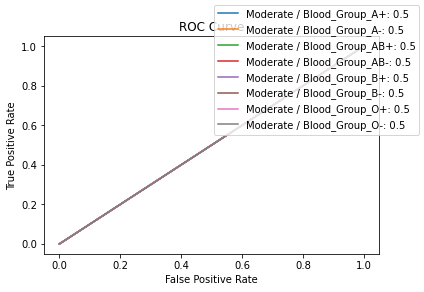

In [23]:
print("Random Forest Classifier")
my_RandomForest = RandomForestClassifier(n_estimators=29, bootstrap=True, random_state=4)
CrossValAndAUC_severity(my_RandomForest,'Moderate')

Random Forest Classifier
Mild / Blood_Group_A+: 0.5
Mild / Blood_Group_A-: 0.5
Mild / Blood_Group_AB+: 0.5
Mild / Blood_Group_AB-: 0.5
Mild / Blood_Group_B+: 0.5
Mild / Blood_Group_B-: 0.5
Mild / Blood_Group_O+: 0.5
Mild / Blood_Group_O-: 0.5


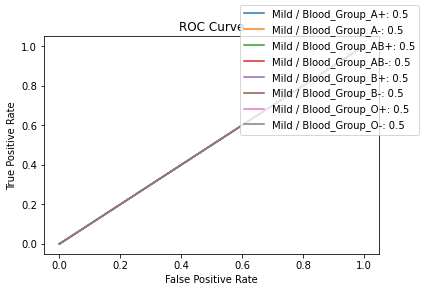

In [24]:
print("Random Forest Classifier")
my_RandomForest = RandomForestClassifier(n_estimators=29, bootstrap=True, random_state=4)
CrossValAndAUC_severity(my_RandomForest,'Mild')

Random Forest Classifier
Severe / Blood_Group_A+: 0.5
Severe / Blood_Group_A-: 0.5
Severe / Blood_Group_AB+: 0.5
Severe / Blood_Group_AB-: 0.5
Severe / Blood_Group_B+: 0.5
Severe / Blood_Group_B-: 0.5
Severe / Blood_Group_O+: 0.5
No Severe samples for the Blood_Group_O-


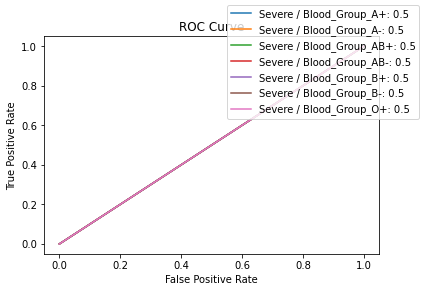

In [25]:
print("Random Forest Classifier")
my_RandomForest = RandomForestClassifier(n_estimators=29, bootstrap=True, random_state=4)
CrossValAndAUC_severity(my_RandomForest,'Severe')

Random Forest Classifier
Critical / Blood_Group_A+: 0.5
Critical / Blood_Group_A-: 0.5
Critical / Blood_Group_AB+: 0.5
No Critical samples for the Blood_Group_AB-
Critical / Blood_Group_B+: 0.5
Critical / Blood_Group_B-: 0.5
Critical / Blood_Group_O+: 0.5
Critical / Blood_Group_O-: 0.5


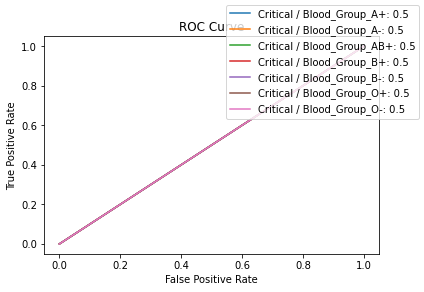

In [26]:
print("Random Forest Classifier")
my_RandomForest = RandomForestClassifier(n_estimators=29, bootstrap=True, random_state=4)
CrossValAndAUC_severity(my_RandomForest,'Critical')

In [27]:
# print("Ada Boost Classifier")
# my_AdaBoost = AdaBoostClassifier(n_estimators=14, random_state=4)
# CrossValAndAUC(my_AdaBoost)

Ada Boost Classifier
Moderate / Blood_Group_A+: 0.5
Moderate / Blood_Group_A-: 0.5
Moderate / Blood_Group_AB+: 0.5
Moderate / Blood_Group_AB-: 0.5
Moderate / Blood_Group_B+: 0.5
Moderate / Blood_Group_B-: 0.5
Moderate / Blood_Group_O+: 0.5
Moderate / Blood_Group_O-: 0.5


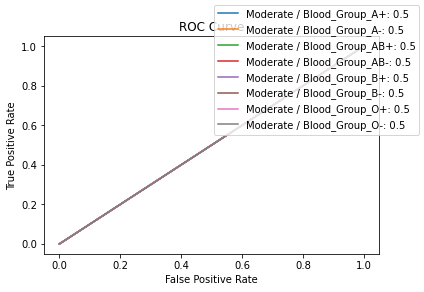

In [28]:
print("Ada Boost Classifier")
my_AdaBoost = AdaBoostClassifier(n_estimators=14, random_state=4)
CrossValAndAUC_severity(my_AdaBoost,'Moderate')

Ada Boost Classifier
Mild / Blood_Group_A+: 0.5
Mild / Blood_Group_A-: 0.5
Mild / Blood_Group_AB+: 0.5
Mild / Blood_Group_AB-: 0.5
Mild / Blood_Group_B+: 0.5
Mild / Blood_Group_B-: 0.5
Mild / Blood_Group_O+: 0.5
Mild / Blood_Group_O-: 0.5


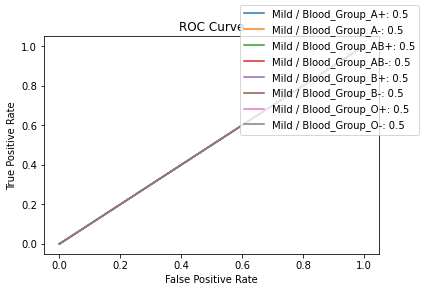

In [29]:
print("Ada Boost Classifier")
my_AdaBoost = AdaBoostClassifier(n_estimators=14, random_state=4)
CrossValAndAUC_severity(my_AdaBoost,'Mild')

Ada Boost Classifier
Severe / Blood_Group_A+: 0.5
Severe / Blood_Group_A-: 0.5
Severe / Blood_Group_AB+: 0.5
Severe / Blood_Group_AB-: 0.5
Severe / Blood_Group_B+: 0.5
Severe / Blood_Group_B-: 0.5
Severe / Blood_Group_O+: 0.5
No Severe samples for the Blood_Group_O-


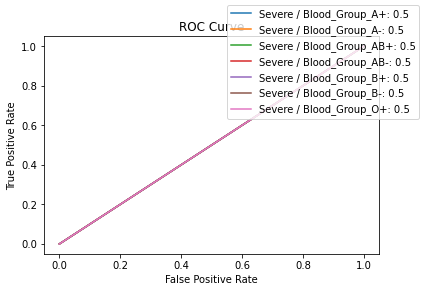

In [30]:
print("Ada Boost Classifier")
my_AdaBoost = AdaBoostClassifier(n_estimators=14, random_state=4)
CrossValAndAUC_severity(my_AdaBoost,'Severe')

Ada Boost Classifier
Critical / Blood_Group_A+: 0.5
Critical / Blood_Group_A-: 0.5
Critical / Blood_Group_AB+: 0.5
No Critical samples for the Blood_Group_AB-
Critical / Blood_Group_B+: 0.5
Critical / Blood_Group_B-: 0.5
Critical / Blood_Group_O+: 0.5
Critical / Blood_Group_O-: 0.5


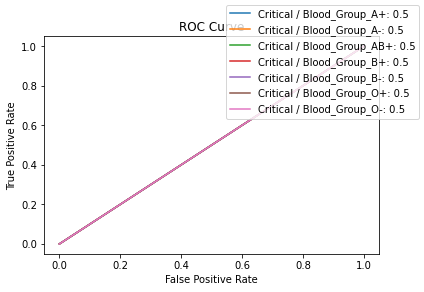

In [31]:
print("Ada Boost Classifier")
my_AdaBoost = AdaBoostClassifier(n_estimators=14, random_state=4)
CrossValAndAUC_severity(my_AdaBoost,'Critical')

In [33]:
# print("SVM")
# my_svm = SVC(kernel='rbf', probability=True)
# CrossValAndAUC(my_svm)

SVM
Moderate / Blood_Group_A+: 0.5
Moderate / Blood_Group_A-: 0.5
Moderate / Blood_Group_AB+: 0.5
Moderate / Blood_Group_AB-: 0.5
Moderate / Blood_Group_B+: 0.5
Moderate / Blood_Group_B-: 0.5
Moderate / Blood_Group_O+: 0.5
Moderate / Blood_Group_O-: 0.5


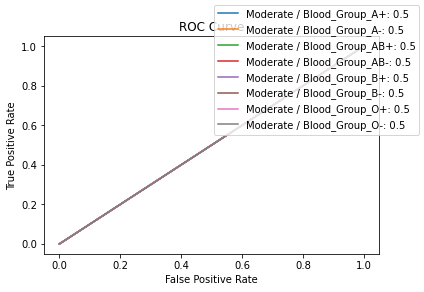

In [34]:
print("SVM")
my_svm = SVC(kernel='rbf', probability=True)
CrossValAndAUC_severity(my_svm,'Moderate')

SVM
Mild / Blood_Group_A+: 0.5
Mild / Blood_Group_A-: 0.5
Mild / Blood_Group_AB+: 0.5
Mild / Blood_Group_AB-: 0.5
Mild / Blood_Group_B+: 0.5
Mild / Blood_Group_B-: 0.5
Mild / Blood_Group_O+: 0.5
Mild / Blood_Group_O-: 0.5


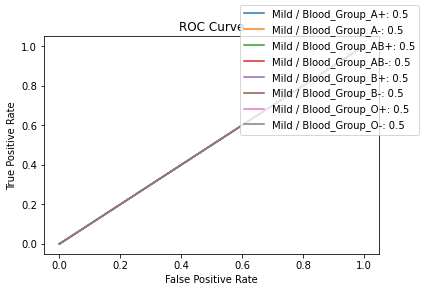

In [35]:
print("SVM")
my_svm = SVC(kernel='rbf', probability=True)
CrossValAndAUC_severity(my_svm,'Mild')

SVM
Severe / Blood_Group_A+: 0.5
Severe / Blood_Group_A-: 0.5
Severe / Blood_Group_AB+: 0.5
Severe / Blood_Group_AB-: 0.5
Severe / Blood_Group_B+: 0.5
Severe / Blood_Group_B-: 0.5
Severe / Blood_Group_O+: 0.5
No Severe samples for the Blood_Group_O-


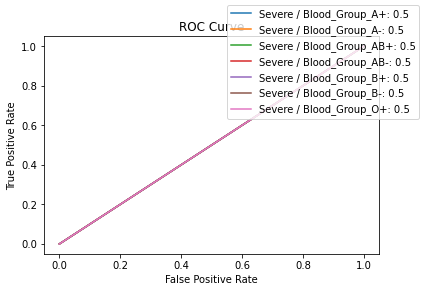

In [36]:
print("SVM")
my_svm = SVC(kernel='rbf', probability=True)
CrossValAndAUC_severity(my_svm,'Severe')

SVM
Critical / Blood_Group_A+: 0.5
Critical / Blood_Group_A-: 0.5
Critical / Blood_Group_AB+: 0.5
No Critical samples for the Blood_Group_AB-
Critical / Blood_Group_B+: 0.5
Critical / Blood_Group_B-: 0.5
Critical / Blood_Group_O+: 0.5
Critical / Blood_Group_O-: 0.5


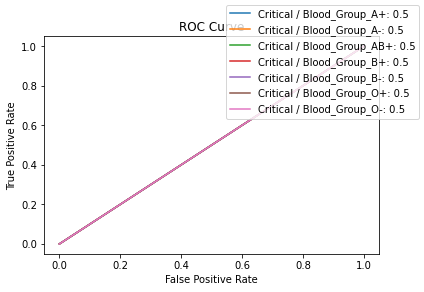

In [37]:
print("SVM")
my_svm = SVC(kernel='rbf', probability=True)
CrossValAndAUC_severity(my_svm,'Critical')